In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils
import tensorflow as tf
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

## **Data Loading**

In [2]:
#Unzip data
!unzip '/content/AlzheimerDataset.zip'

Archive:  /content/AlzheimerDataset.zip
   creating: Dataset/MildDemented/
  inflating: Dataset/MildDemented/mildDem0.jpg  
  inflating: Dataset/MildDemented/mildDem1.jpg  
  inflating: Dataset/MildDemented/mildDem10.jpg  
  inflating: Dataset/MildDemented/mildDem100.jpg  
  inflating: Dataset/MildDemented/mildDem101.jpg  
  inflating: Dataset/MildDemented/mildDem102.jpg  
  inflating: Dataset/MildDemented/mildDem103.jpg  
  inflating: Dataset/MildDemented/mildDem104.jpg  
  inflating: Dataset/MildDemented/mildDem105.jpg  
  inflating: Dataset/MildDemented/mildDem106.jpg  
  inflating: Dataset/MildDemented/mildDem107.jpg  
  inflating: Dataset/MildDemented/mildDem108.jpg  
  inflating: Dataset/MildDemented/mildDem109.jpg  
  inflating: Dataset/MildDemented/mildDem11.jpg  
  inflating: Dataset/MildDemented/mildDem110.jpg  
  inflating: Dataset/MildDemented/mildDem111.jpg  
  inflating: Dataset/MildDemented/mildDem112.jpg  
  inflating: Dataset/MildDemented/mildDem113.jpg  
  inflating: 

In [3]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root =  '/content/Dataset/'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'MildDemented': 500, 'NonDemented': 500}

So we have 500 Demented Brain MRI scans and 500 Non Demented or healthy MRI scans.

Text(0.5, 1.0, 'Non Demented')

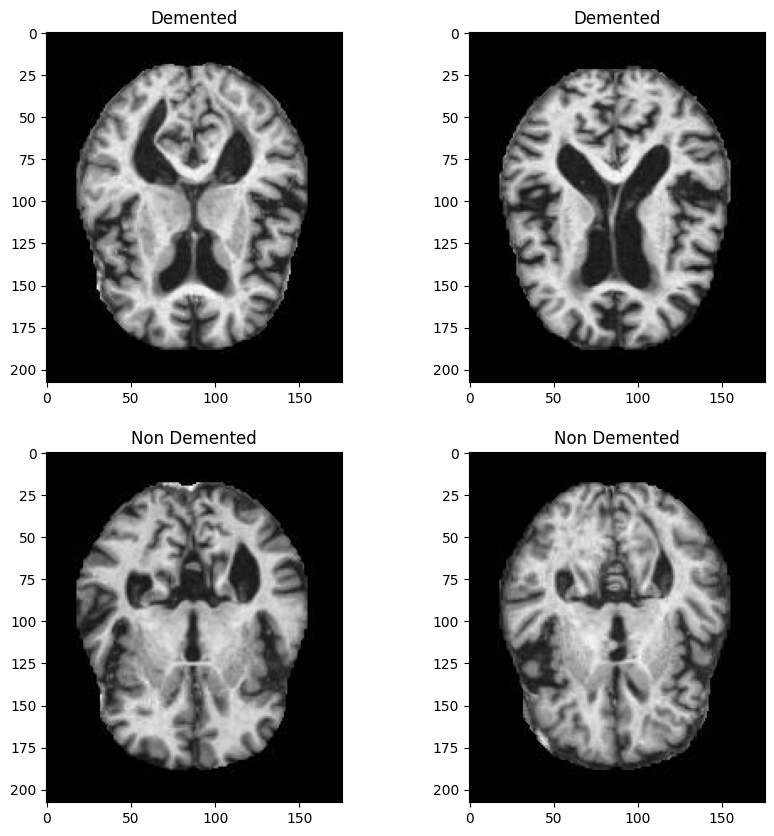

In [4]:
#Plot some MRI images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('MildDemented', os.listdir('MildDemented')[0])))
plt.title('Demented')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('MildDemented', os.listdir('MildDemented')[1])))
plt.title('Demented')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('NonDemented', os.listdir('NonDemented')[0])))
plt.title('Non Demented')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('NonDemented', os.listdir('NonDemented')[1])))
plt.title('Non Demented')

## **Image Augmentation**

As much as our training set contains more data, the model's accuracy will improve. Data augmentation is a technique used to increase the amount of data by adding slightly modified copies of already existing data.

In [5]:
#Define a function for image augmentation
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
#Create augmented images folders
#L = ['aug_train', 'aug_test', 'aug_val']
name = 'aug_data'
if not os.path.exists("/content/"+name):
  os.mkdir("/content/"+name)
  for dir in os.listdir(root):
    os.makedirs("/content/"+name+"/"+dir)
else:
  print(f"{name} Already exists")

In [7]:
#Augment data for the examples with the label 'MildDemented' in the training set
augment_data(file_dir='/content/Dataset/MildDemented/',n_generated_samples=8, save_to_dir='/content/aug_data/MildDemented')
#Augment data for the examples with the label 'NonDemented' in the training set
augment_data(file_dir='/content/Dataset/NonDemented/', n_generated_samples=12, save_to_dir='/content/aug_data/NonDemented')

## **Split data into train, validation and test sets**

In [8]:
# Count images in the two folders: yes (Tumor) and no (Healthey) in the folder of augmented images
root =  '/content/aug_data/'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img

{'MildDemented': 4497, 'NonDemented': 6493}

In [9]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [10]:
#Create the training set
create_folders('train', 0.7)

In [11]:
#Create the test set
create_folders('test', 0.15)

In [12]:
#Create the validation set
create_folders('val', 0.15)

In [13]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [14]:
#Count images in the training set
count_img('train')

{'MildDemented': 3147, 'NonDemented': 4545}

In [15]:
#Count images in the test set
count_img('test')

{'MildDemented': 674, 'NonDemented': 973}

In [16]:
#Count images in the validation set
count_img('val')

{'MildDemented': 674, 'NonDemented': 973}

In [ ]:
# #Define a function for image augmentation
# def augment_data2(file_dir, n_generated_samples, save_to_dir):
#     data_gen = ImageDataGenerator(rescale = 1/255)

#     for filename in os.listdir(file_dir):
#         image = cv2.imread(file_dir + '/' + filename)
#         # reshape the image
#         image = image.reshape((1,)+image.shape)
#         save_prefix = 'aug_' + filename[:-4]
#         i=0
#         for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break

In [ ]:
# #Augment data for the examples with the label 'yes' in the test set
# augment_data2(file_dir='./test/yes',n_generated_samples=8, save_to_dir='./aug_test/yes')
# #Augment data for the examples with the label 'no' in the training set
# augment_data2(file_dir='./test/no', n_generated_samples=12, save_to_dir='./aug_test/no')

In [ ]:
# #Augment data for the examples with the label 'yes' in the validation set
# augment_data2(file_dir='./val/yes',n_generated_samples=8, save_to_dir='./aug_val/yes')
# #Augment data for the examples with the label 'no' in the training set
# augment_data2(file_dir='./val/no', n_generated_samples=12, save_to_dir='./aug_val/no')

In [ ]:
# #Count images in the training set
# count_img('aug_train')

In [ ]:
# #Count images in the training set
# count_img('aug_test')

In [18]:
# #Count images in the training set
# count_img('aug_val')

## **Image Preprocessing**

In [17]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):

    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

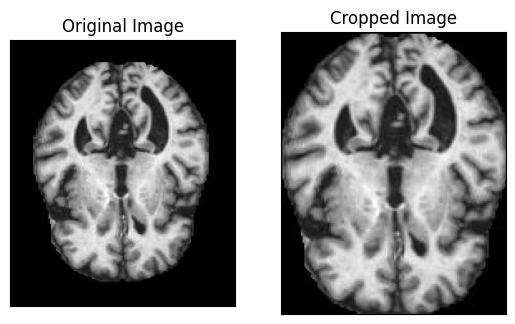

In [19]:
#Example
ex_img = cv2.imread('/content/MildDemented/mildDem104.jpg')
img = crop_brain_contour(ex_img, plot=True)

In [20]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-12:] == 'MildDemented':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/MildDemented', '/content/train/NonDemented'], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Mild Demented" if label == 1 else "Non Demented"
        plt.suptitle(f"\n Alzheimer : {label_to_str(label)}")
        plt.show()

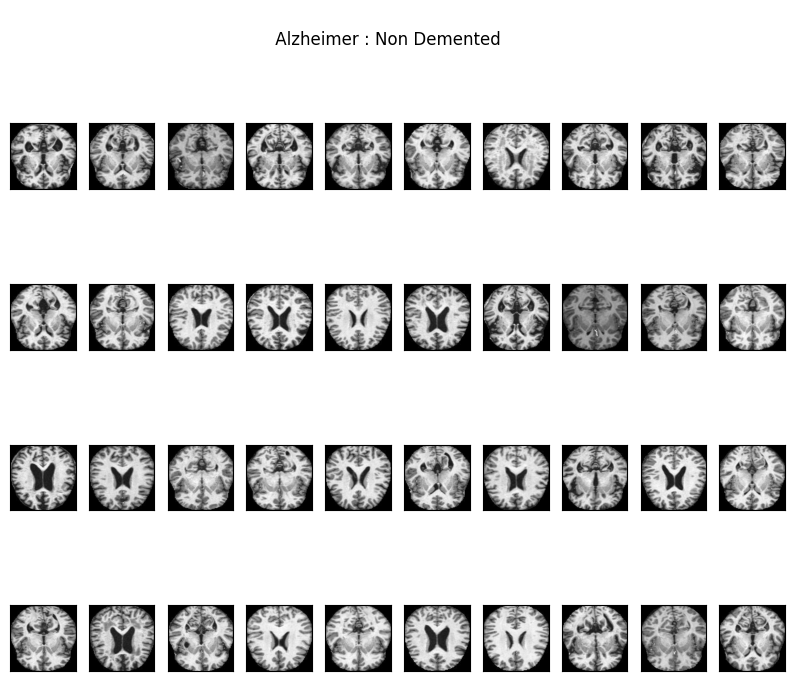

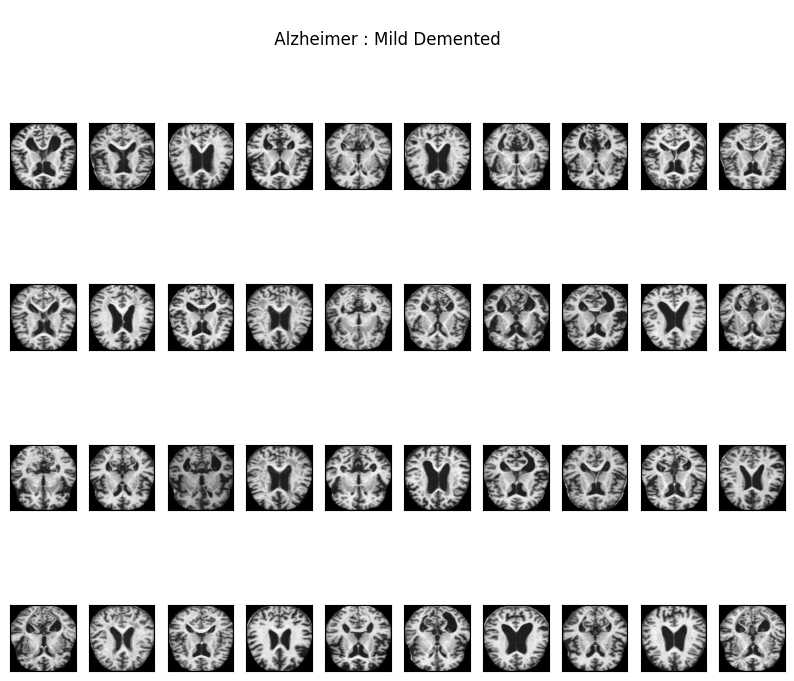

In [ ]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

We can notice that the noise has been deleted from the images which makes it more easier for the model to study

In [ ]:
#Load test data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/MildDemented', '/content/test/NonDemented'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 194
X shape is: (194, 240, 240, 3)
y shape is: (194, 1)


In [ ]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/MildDemented', '/content/val/NonDemented'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 194
X shape is: (194, 240, 240, 3)
y shape is: (194, 1)


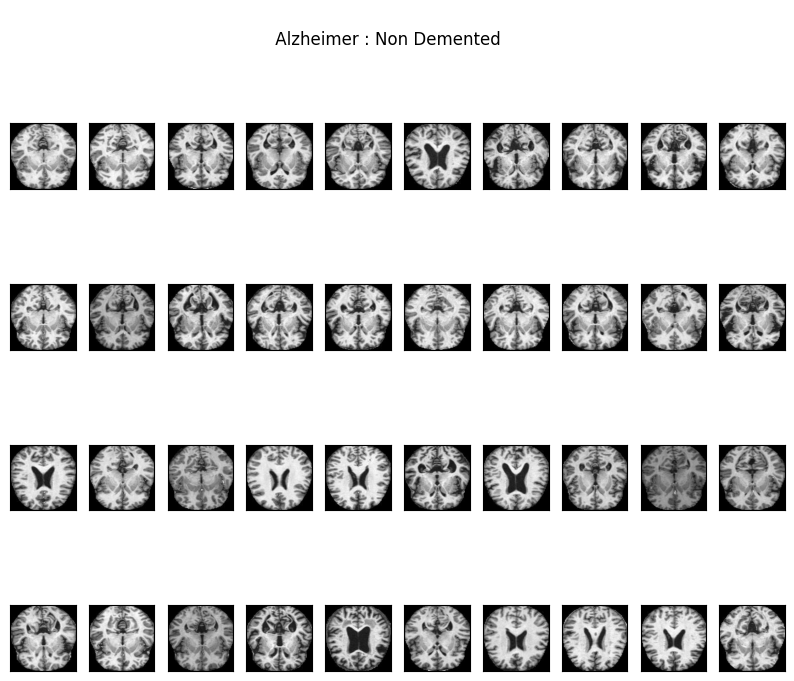

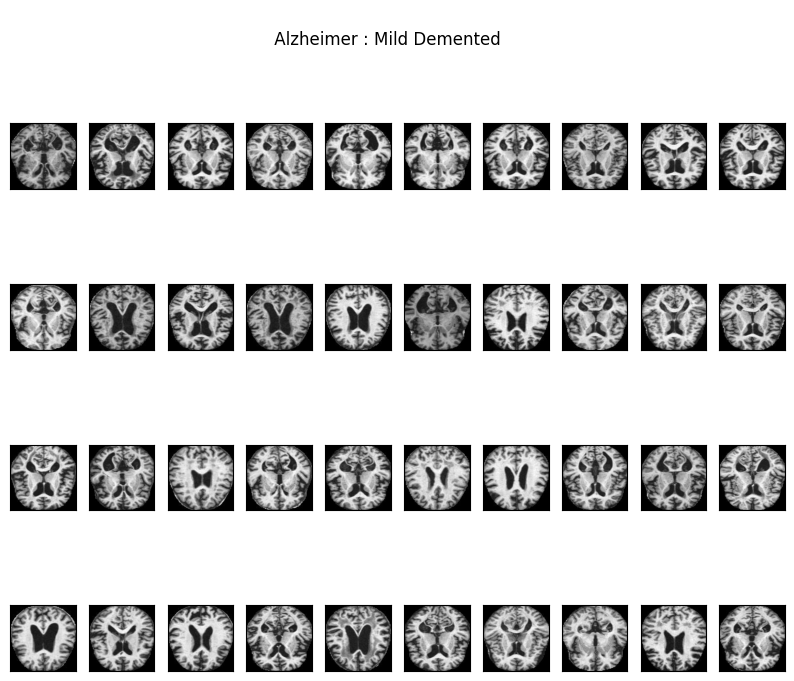

In [ ]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

## **CNN Model**

In [ ]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       7

In [ ]:
#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestadmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [ ]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 0.6377 - accuracy: 0.6443
Epoch 1: val_accuracy improved from -inf to 0.80928, saving model to ./bestadmodel.h5
29/29 [==============================] - 19s 182ms/step - loss: 0.6377 - accuracy: 0.6443 - val_loss: 0.4333 - val_accuracy: 0.8093
Epoch 2/30
28/29 [===========================>..] - ETA: 0s - loss: 0.3749 - accuracy: 0.8281
Epoch 2: val_accuracy improved from 0.80928 to 0.88144, saving model to ./bestadmodel.h5
29/29 [==============================] - 4s 134ms/step - loss: 0.3782 - accuracy: 0.8271 - val_loss: 0.2993 - val_accuracy: 0.8814
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8767
Epoch 3: val_accuracy did not improve from 0.88144
29/29 [==============================] - 4s 129ms/step - loss: 0.2827 - accuracy: 0.8767 - val_loss: 0.4198 - val_accuracy: 0.8402
Epoch 4/30
28/29 [===========================>..] - ETA: 0s - loss: 0.2016 - accuracy: 0.9174
Epoc

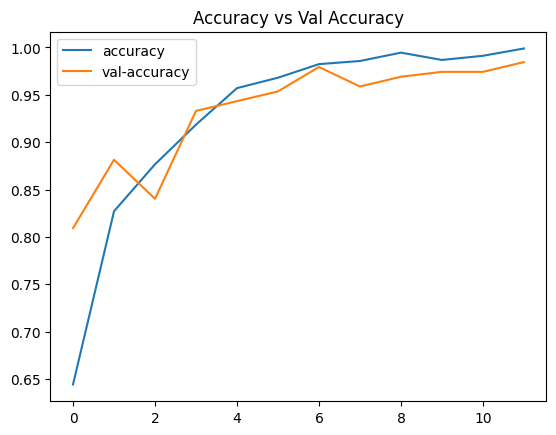

In [ ]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

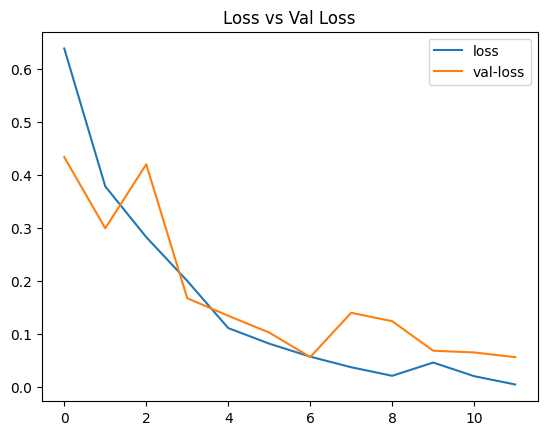

In [ ]:
#Plot the graphical interpretation
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/bestadmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

7/7 [==============================] - 0s 33ms/step - loss: 0.0999 - accuracy: 0.9742
The accuracy of our model is 0.9742268323898315


We can see that our model works well on the test set, so it's not overfitted

In [ ]:
#Try our model on a random image that it has never seen before
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Choose a MRI image with alzheimer
path = "/content/Dataset2/MildDemented/mildDem73.jpg"
img_dem = load_img(path, target_size=(240,240))
img_array_dem = img_to_array(img_dem)/255
img_array_dem = np.expand_dims(img_array_dem, axis=0)
prediction1 = model.predict(img_array_dem)
class1 = np.round(prediction1).astype(int)
if class1 == 0:
  print("The MRI image doesn't have alzheimer")
else:
  print("The MRI image has alzheimer")

1/1 [==============================] - 0s 19ms/step
The MRI image has alzheimer


In [ ]:
#Try our model on a random image that it has never seen before
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Choose a MRI image without alzheimer
path = "/content/Dataset2/NonDemented/nonDem363.jpg"
img_nondem = load_img(path, target_size=(240,240))
img_array_nondem = img_to_array(img_nondem)/255
img_array_nondem = np.expand_dims(img_array_nondem, axis=0)
prediction2 = model.predict(img_array_nondem)[0][0]
class2 = np.round(prediction2).astype(int)
if class2 == 0:
  print("The MRI image doesn't have alzheimer")
else:
  print("The MRI image has alzheimer")

1/1 [==============================] - 0s 74ms/step
The MRI image doesn't have alzheimer


## **Transfer Learning**

In [ ]:
#Import MobileNet Model
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
#Make the layers of the model untrainable
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
#Add a flatten and dense layers to the base model
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 120, 120, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 120, 120, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 120, 120, 32)     128       
 ation)                                                      

In [ ]:
#Compile the new model
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
#Early stopping and model checkpoint
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestadtransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cdt = [est, mct]

In [ ]:
#Fit our new model
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
29/29 [==============================] - ETA: 0s - loss: 4.3036 - accuracy: 0.7313
Epoch 1: val_accuracy improved from -inf to 0.69072, saving model to ./bestadtransfermodel.h5
29/29 [==============================] - 6s 108ms/step - loss: 4.3036 - accuracy: 0.7313 - val_loss: 3.5122 - val_accuracy: 0.6907
Epoch 2/30
29/29 [==============================] - ETA: 0s - loss: 1.6260 - accuracy: 0.8260
Epoch 2: val_accuracy improved from 0.69072 to 0.89691, saving model to ./bestadtransfermodel.h5
29/29 [==============================] - 2s 58ms/step - loss: 1.6260 - accuracy: 0.8260 - val_loss: 0.6618 - val_accuracy: 0.8969
Epoch 3/30
29/29 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.8899
Epoch 3: val_accuracy improved from 0.89691 to 0.94330, saving model to ./bestadtransfermodel.h5
29/29 [==============================] - 2s 60ms/step - loss: 1.0719 - accuracy: 0.8899 - val_loss: 0.2659 - val_accuracy: 0.9433
Epoch 4/30
28/29 [=====================

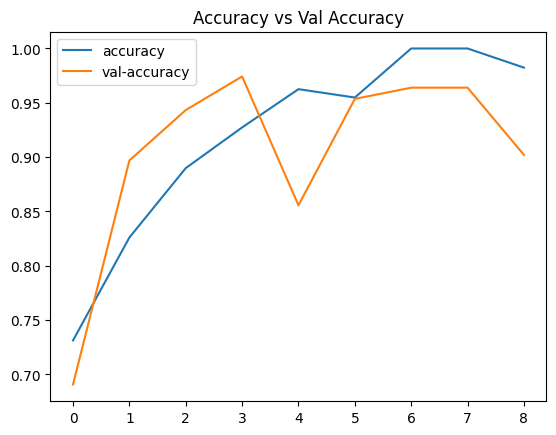

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

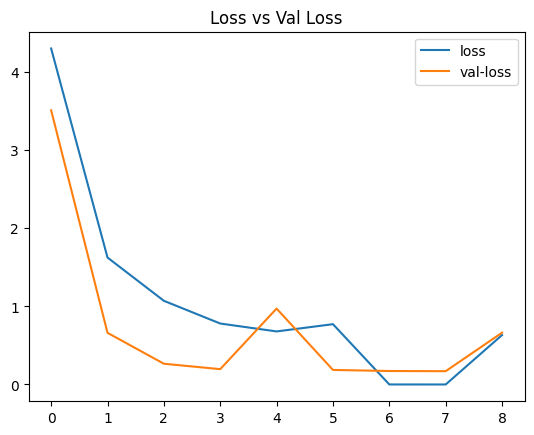

In [ ]:
#Plot the graphical interpretation
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [ ]:
#Test our model on the test set
from keras.models import load_model
model = load_model('/content/bestadtransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

7/7 [==============================] - 1s 46ms/step - loss: 0.3357 - accuracy: 0.9536
The accuracy of our model is 0.9536082744598389


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# tf.compat.v1.enable_eager_execution()

In [ ]:
# tf.saved_model.save(model, '/content/drive/My Drive/')

In [ ]:
# pip install onnx-tf